In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 1
%aimport utils, GroupingAlgorithm

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import networkx as nx
import warnings
from utils import number2SummedOp, Label2Chain
from qiskit.algorithms import NumPyMinimumEigensolver

%matplotlib widget

/home/dfernandez/anaconda3/envs/heem/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


# $H_20$ grouping vs $x$ (w/ shuffle)

In [2]:
file = 'H20_grouping_shuffle_ideal_vs_connectivity'
data = np.load(file + '.npy', allow_pickle=True).item()

print(data.keys())

for key in data:
    vars()[key] = data[key]

dict_keys(['x_vec', 'n_groups', 'optimal_order_paulis', 'optimal_order_qubits', 'optimal_graph'])


In [3]:
n_x = len(x_vec)

n_std = np.zeros(n_x)
n_avg = np.zeros(n_x)
n_min = np.zeros(n_x)
n_max = np.zeros(n_x)

for i in range(n_x):
    n_std[i] = np.std(n_groups[i])
    n_avg[i] = np.mean(n_groups[i])
    n_min[i] = np.min(n_groups[i])
    n_max[i] = np.max(n_groups[i])

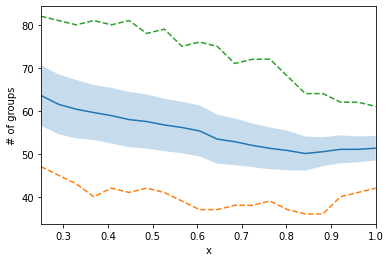

In [4]:
fig, ax = plt.subplots()
ax.plot(x_vec, n_avg)
ax.fill_between(x_vec, n_avg - n_std, n_avg + n_std, alpha=0.25)
ax.plot(x_vec, n_min, '--')
ax.plot(x_vec, n_max, '--')
ax.set_xlabel('x')
ax.set_ylabel('# of groups')
ax.set_xlim([x_vec[0], x_vec[-1]]);

In [5]:
index_min = np.argmin(n_min)
print('The minumum number of groups is {:.0f}, obtained for x = {:.3f}'.format(n_min[index_min], x_vec[index_min]))

The minumum number of groups is 36, obtained for x = 0.842


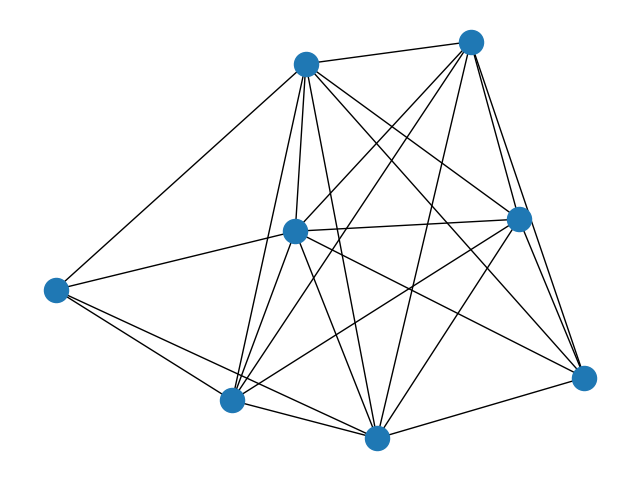

In [14]:
plt.figure()
nx.draw(optimal_graph[index_min])

# Optimal VQE

In [58]:
molecule = 'LiH'
name_backend = 'ibmq_montreal'
data = np.load('../data/VQE_' + molecule + '_ibmq_montreal.npy', allow_pickle=True).item()

data_qubit_op = np.load('../data/optimal_grouping_' + molecule + '_' + name_backend + '.npy', allow_pickle=True).item()
qubit_op = number2SummedOp(data_qubit_op['optimal_labels'], data_qubit_op['optimal_coeffs'])
num_qubits = qubit_op.num_qubits
paulis, _, _ = Label2Chain(qubit_op)

n_groups = data_qubit_op['n_groups']

result_exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
print('The exact energy is: {:.3f}'.format(np.real(result_exact.eigenvalue)))

print(n_groups)

The exact energy is: -1.089
{'TPB': 25, 'EM': 15, 'HEEM': 10}


In [59]:
energies.shape

(510, 100)

In [61]:
labels = ['TPB', 'EM', 'HEEM']
x_axis = 'circuits'

fig, ax = plt.subplots()
for label in labels:    
    energies_temp = data[label][:, 50:]
    energies = np.zeros([energies_temp.shape[0], energies_temp.shape[1] // 2])
    for i in range(energies_temp.shape[1] // 2):
        energies[:, i] = np.mean(energies_temp[:, 2 * i: 2 * i + 2], axis=1)
    
    
    x_vec = np.arange(0, len(energies[0]))
    if x_axis == 'circuits':
        x_vec *= n_groups[label]
        
#     line = ax.plot(x_vec, np.min(energies, axis=0), ls='-')
#     ax.plot(x_vec, np.max(energies, axis=0), ls='-',  c=line[0].get_color())
    
    std = np.std(energies, axis=0)
    avg = np.mean(energies, axis=0)
    
    line = ax.plot(x_vec, avg, label=label)
    ax.fill_between(x_vec, avg - std, avg + std, alpha=0.2)
    for i in range(2):
        ax.plot(x_vec, avg + (-1) ** i * std, ls='-', alpha=0.3, c=line[0].get_color())

ax.plot([np.real(result_exact.eigenvalue)] * len(avg) * n_groups['TPB'], 'k--', label='Exact')

if x_axis == 'iterations':
    ax.set_xlabel('iterations')
    ax.set_xlim([0, (len(std) - 1)])
elif x_axis == 'circuits':
    ax.set_xlabel('number of circuits')
    ax.set_xlim([0, (len(std) - 1) * n_groups['TPB']])
    
ax.set_ylabel('energy [Ha]')
ax.legend()
ax.set_title(molecule);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Universal grouping

In [53]:
data = np.load('../data/comparison_grouping_algorithms.npy', allow_pickle=True).item()

In [54]:
labels = ['naive', 'order_disconnected', 'order_connected']
colors = ['C0', 'C1', 'C2']

fig, ax = plt.subplots()

w_spacing = 0.0  # Spacing between bar of equal n_qubits
w_spacing_big = 0.1  # Spacing between bars of different n_qubits
w_bar = (1 - 2 * w_spacing_big - 2 * w_spacing) / 3
delta = 1 / 2 - w_spacing_big - w_bar / 2

ticks_labels = list(data.keys())
order = []
for (j, n_qubit) in enumerate(data.keys()):
    if data[n_qubit]['parameters']['n_paulis'] < 4 ** int(n_qubit):
        ticks_labels[j] += '*'
    for (i, label) in enumerate(labels):
        ax.bar(int(n_qubit) + delta * (i - 1), np.mean(data[n_qubit][label]), width=w_bar, color=colors[i], zorder=3,
               yerr = np.std(data[n_qubit][label]), ecolor='black', capsize=4,
               label=label if n_qubit == min(data.keys()) else None)

        
ax.set_xticks(range(min([int(x) for x in data.keys()]), max([int(x) for x in data.keys()]) + 1))
ax.set_xticklabels(np.array(ticks_labels)[np.argsort([int(i) for  i in data.keys()])])
ax.set_xlabel('number of qubits')
ax.set_ylabel('average number of groups')
ax.yaxis.grid(zorder=0)
ax.legend()
ax.set_title('Random Pauli strings ({})'.format(list(data.values())[0]['parameters']['name_backend']));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [9]:
fig, ax = plt.subplots()
for (i, label) in enumerate(labels):
    data_plot_x = np.array([int(x) for x in data.keys()])
    indices_sort = np.argsort(data_plot_x)
    data_plot_y = np.array([data[n_qubit]['times'][label] / len(data[n_qubit][label]) / 60 for n_qubit in data.keys()])
    ax.plot(data_plot_x[indices_sort], data_plot_y[indices_sort], c=colors[i], label=label, marker='.')
        
ax.legend()
# ax.set_yscale('log')
ax.set_xlabel('number of qubits')
ax.set_ylabel('average time (min)')
ax.set_title('Random Pauli strings ({})'.format(list(data.values())[0]['parameters']['name_backend']));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Comparing grouping for molecules

In [17]:
algorithm = 'HEEM'
data = np.load('../data/comparison_grouping_algorithms_molecules_' + algorithm + '.npy', allow_pickle=True).item()
n_qubits = {'H2': 2, 'LiH': 4, 'BeH2': 6, 'H2O': 8, 'CH4': 10, 'C2H2': 16}
ticks_labels = [r'$H_2$', r'$LiH$', r'$BeH_2$', r'$H_2O$', r'$CH_4$', r'$C_2H_2$']
print_shots = True

for (j, molecule) in enumerate(n_qubits.keys()):
    ticks_labels[j] += ' ({})'.format(n_qubits[molecule])
    
    try:
        n = len(data[molecule]['naive'])
    except:
        n = 0
    
    print('Montercarlo shots for {}: {}'.format(molecule, n))
    
    if print_shots:
        temp = '{:.1e}'.format(n).split('+')
        exponent = r'\times 10^{{{}}}$'.format(int(temp[1]))
        ticks_labels[j] += '\n[' + '$' + temp[0][:3] + exponent +']'

Montercarlo shots for H2: 18941760
Montercarlo shots for LiH: 5409792
Montercarlo shots for BeH2: 3902976
Montercarlo shots for H2O: 206208
Montercarlo shots for CH4: 24192
Montercarlo shots for C2H2: 3444


In [18]:
labels = ['naive', 'order_disconnected', 'order_connected']

for molecule in n_qubits.keys():
    n_min = np.infty
    for label in labels: 
        try:
            n_min = min(n_min, np.min(data[molecule][label]))            
        except KeyError:
            pass
        
    if n_min != np.infty:
        print('The minimum number of groups for {} ({} qubits) is {}'.format(molecule, n_qubits[molecule], int(n_min)))

The minimum number of groups for H2 (2 qubits) is 2
The minimum number of groups for LiH (4 qubits) is 10
The minimum number of groups for BeH2 (6 qubits) is 13
The minimum number of groups for H2O (8 qubits) is 47
The minimum number of groups for CH4 (10 qubits) is 117
The minimum number of groups for C2H2 (16 qubits) is 258


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
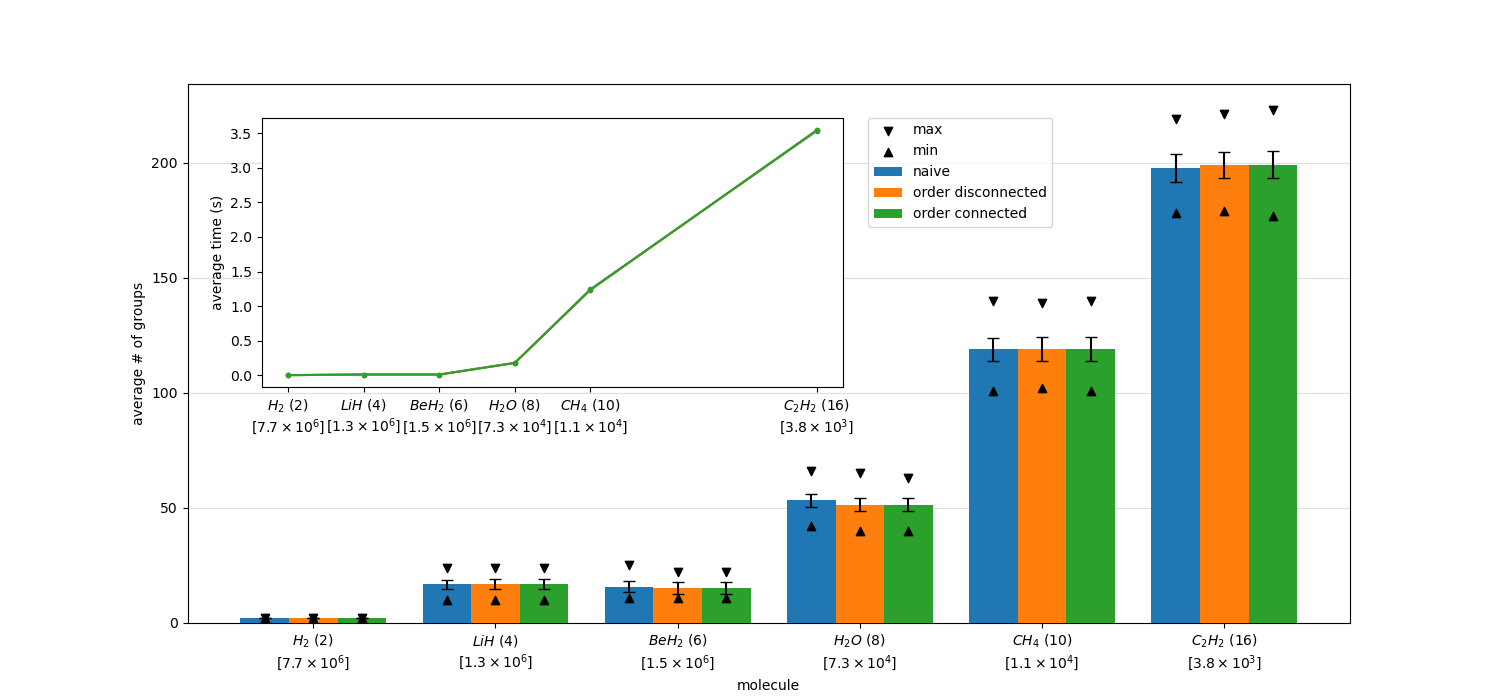

In [4]:
labels = ['naive', 'order_disconnected', 'order_connected']
colors = ['C0', 'C1', 'C2']

# plt.style.use('science')
plt.style.use('default')
fig, ax = plt.subplots(figsize=(15, 7))

w_spacing = 0.0  # Spacing between bar of equal n_qubits
w_spacing_big = 0.1  # Spacing between bars of different n_qubits
w_bar = (1 - 2 * w_spacing_big - 2 * w_spacing) / 3
delta = 1 / 2 - w_spacing_big - w_bar / 2

# ticks_labels = list(n_qubits.keys())
legend = True
for (j, molecule) in enumerate(n_qubits.keys()):
    try:
        for (i, label) in enumerate(labels):
            ax.bar(j + delta * (i - 1), np.mean(data[molecule][label]), width=w_bar, color=colors[i], zorder=3,
                   yerr = np.std(data[molecule][label]), ecolor='black', capsize=4, label=label.replace('_', ' ') if legend else None)
            # ax.hlines(np.min(data[molecule][label]), j + delta * (i - 1) - w_bar / 2, j + delta * (i - 1) + w_bar / 2, zorder=4, color='k', ls='--')
            # ax.vlines(j + delta * (i - 1), np.min(data[molecule][label]), np.max(data[molecule][label]), zorder=4, color='r', ls='--')
            ax.scatter(j + delta * (i - 1), np.max(data[molecule][label]), zorder=4, color='k', marker='v', label='max' if (legend and not i) else None)
            ax.scatter(j + delta * (i - 1), np.min(data[molecule][label]), zorder=4, color='k', marker='^', label='min' if (legend and not i) else None)
        legend = False
        
    except:
        pass
        
ax.set_xticks(range(0, len(n_qubits.keys())))
ax.set_xticklabels(ticks_labels)
ax.set_xlabel('molecule')
ax.set_ylabel('average # of groups')
ax.yaxis.grid(zorder=0, alpha=0.4)
# ax.set_title('Molecules Pauli strings ({})'.format(list(data.values())[0]['parameters']['name_backend']))
ax.legend(bbox_to_anchor=(0.75, 0.95))

axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(0.07, .45, .5, .5),
                   bbox_transform=ax.transAxes)


for (i, label) in enumerate(labels):
    data_plot_x = []
    data_plot_y = []
    for molecule in n_qubits.keys():
        try:
            data_plot_y.append(data[molecule]['times'][label] / len(data[molecule][label]))
            data_plot_x.append(n_qubits[molecule])
        except:
            pass
    
    axins.plot(data_plot_x, data_plot_y, c=colors[i], marker='.')
        
axins.set_ylabel('average time (s)')

axins.set_xticks(list(n_qubits.values()))
# axins.set_yscale('log')
axins.set_xticklabels(ticks_labels);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
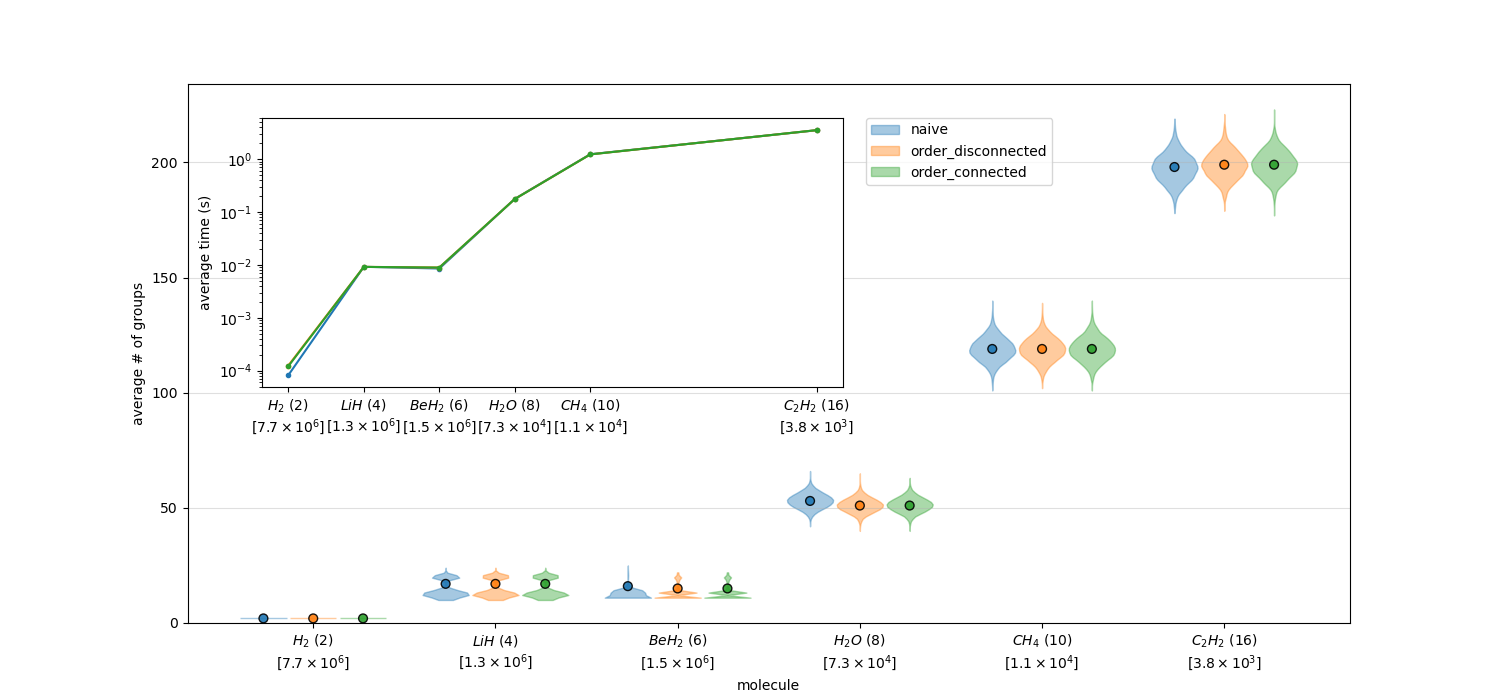

In [5]:
labels = ['naive', 'order_disconnected', 'order_connected']
colors = ['C0', 'C1', 'C2']

fig, ax = plt.subplots(figsize=(15, 7))

w_spacing = 0.02  # Spacing between bar of equal n_qubits
w_spacing_big = 0.1  # Spacing between bars of different n_qubits
w_bar = (1 - 2 * w_spacing_big - 2 * w_spacing) / 3
delta = 1 / 2 - w_spacing_big - w_bar / 2

x_pos_mean = []
y_pos_mean = []
color_mean = []
legend = True
labels_legend = []

for (j, molecule) in enumerate(n_qubits.keys()):
    try:
        for (i, label) in enumerate(labels):
            violin_parts = ax.violinplot(data[molecule][label], showextrema=False, positions=[j + delta * (i - 1)], widths=w_bar,
                                         points=max(1, int(np.max(data[molecule][label]) - np.min(data[molecule][label]))))
            
            for pc in violin_parts['bodies']:
                pc.set_facecolor(colors[i])
                pc.set_edgecolor(colors[i])
                pc.set_alpha(0.4)
                
            x_pos_mean.append(j + delta * (i - 1))
            y_pos_mean.append(np.median(data[molecule][label]))
            color_mean.append(colors[i])
            
            if legend:
                color = violin_parts["bodies"][0].get_facecolor().flatten()
                labels_legend.append((mpatches.Patch(color=color), label))
        legend = False
    except:
        pass
    
ax.scatter(x_pos_mean, y_pos_mean, marker='o', c=color_mean, s=40, zorder=3, alpha=0.9, edgecolors='k')

ax.set_xticks(range(0, len(n_qubits.keys())))
ax.set_xticklabels(ticks_labels)
ax.set_xlabel('molecule')
ax.set_ylabel('average # of groups')
ax.set_ylim([0, ax.get_ylim()[1]])

ax.yaxis.grid(zorder=0, alpha=0.4)
# ax.set_title('Molecules Pauli strings ({})'.format(list(data.values())[0]['parameters']['name_backend']))
ax.legend(*zip(*labels_legend), bbox_to_anchor=(0.75, 0.95))

axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(0.07, .45, .5, .5),
                   bbox_transform=ax.transAxes)


for (i, label) in enumerate(labels):
    data_plot_x = []
    data_plot_y = []
    for molecule in n_qubits.keys():
        try:
            data_plot_y.append(data[molecule]['times'][label] / len(data[molecule][label]))
            data_plot_x.append(n_qubits[molecule])
        except:
            pass
    
    axins.plot(data_plot_x, data_plot_y, c=colors[i], marker='.')
        
axins.set_ylabel('average time (s)')
axins.set_yscale('log')

axins.set_xticks(list(n_qubits.values()))
axins.set_xticklabels(ticks_labels);

# Grouping with different devices

In [82]:
molecule_name = 'C2H2'
data = np.load('../data/grouping_devices_{}.npy'.format(molecule_name), allow_pickle=True).item()
data['huge']

print('Montecarlo shots = {}'.format(len(data['huge']['naive'])))

Montecarlo shots = 420


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
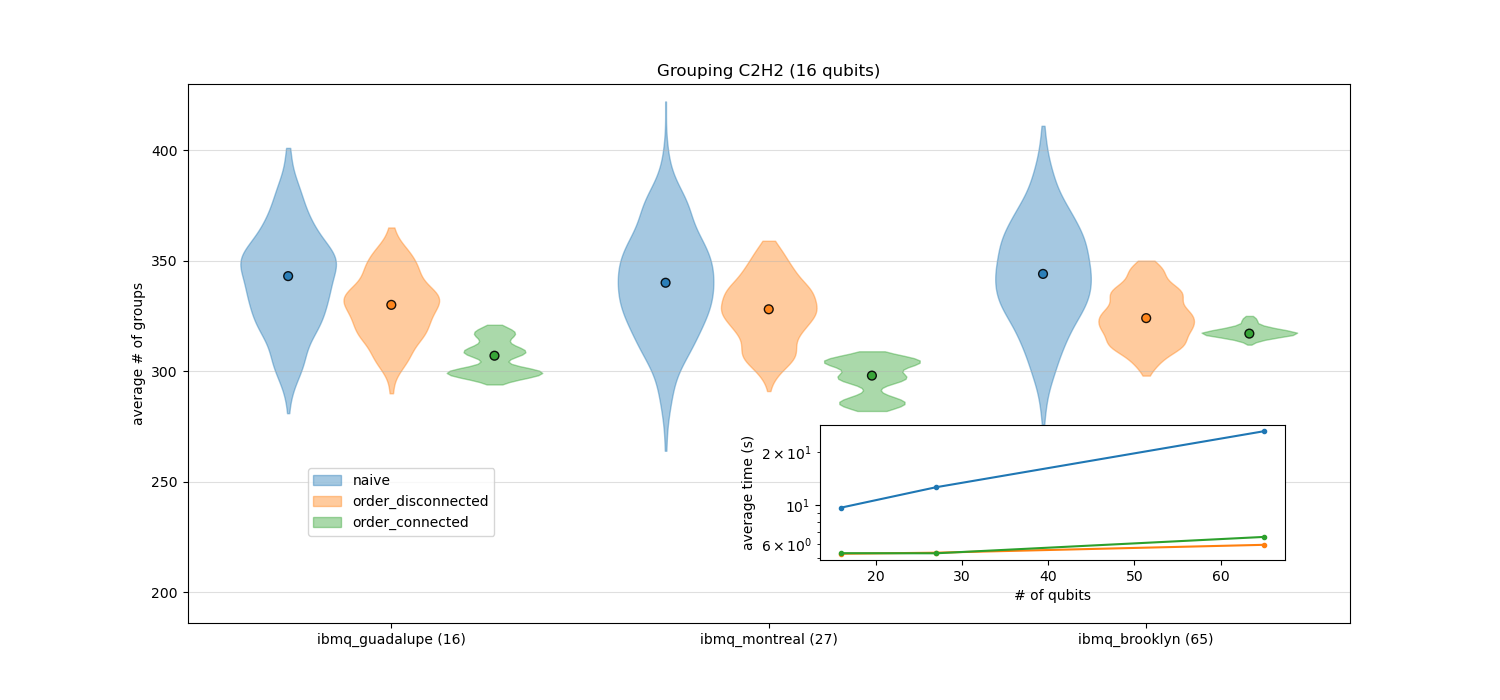

In [83]:
chips = ['small', 'big', 'huge']
labels = ['naive', 'order_disconnected', 'order_connected']
colors = ['C0', 'C1', 'C2']
n_qubits_device = {'huge': 65, 'big': 27, 'small': 16}
ticks_labels = []
for chip in chips:
    ticks_labels.append(data['parameters']['name_' + chip] + ' ({})'.format(n_qubits_device[chip]))

fig, ax = plt.subplots(figsize=(15, 7))

w_spacing = 0.02  # Spacing between bar of equal n_qubits
w_spacing_big = 0.1  # Spacing between bars of different n_qubits
w_bar = (1 - 2 * w_spacing_big - 2 * w_spacing) / 3
delta = 1 / 2 - w_spacing_big - w_bar / 2

x_pos_mean = []
y_pos_mean = []
color_mean = []
legend = True
labels_legend = []

for (j, chip) in enumerate(chips):
    for (i, label) in enumerate(labels):
        violin_parts = ax.violinplot(data[chip][label], showextrema=False, positions=[j + delta * (i - 1)], widths=w_bar,
                                         points=max(1, int(np.max(data[chip][label]) - np.min(data[chip][label]))))
                                     # points=4)
            
        for pc in violin_parts['bodies']:
            pc.set_facecolor(colors[i])
            pc.set_edgecolor(colors[i])
            pc.set_alpha(0.4)
                
        x_pos_mean.append(j + delta * (i - 1))
        y_pos_mean.append(np.median(data[chip][label]))
        color_mean.append(colors[i])
            
        if legend:
            color = violin_parts["bodies"][0].get_facecolor().flatten()
            labels_legend.append((mpatches.Patch(color=color), label))
            
    legend = False
    
ax.scatter(x_pos_mean, y_pos_mean, marker='o', c=color_mean, s=40, zorder=3, alpha=0.9, edgecolors='k')
    
ax.set_xticks(range(0, 3))
ax.set_xticklabels(ticks_labels)
ax.set_ylabel('average # of groups')
# ax.set_xlabel('device')
ax.set_ylim([ax.get_ylim()[0] - 70, ax.get_ylim()[1]])

ax.yaxis.grid(zorder=0, alpha=0.4)
ax.set_title('Grouping ' + molecule_name + ' ({} qubits)'.format(data['parameters']['n_qubits_molecule']))
ax.legend(*zip(*labels_legend), bbox_to_anchor=(0.27, 0.3))

axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(0.55, .13, .4, .25),
                   bbox_transform=ax.transAxes)

for (i, label) in enumerate(labels):
    data_plot_x = []
    data_plot_y = []
    for chip in chips:
        data_plot_y.append(data['time'][chip][label] / len(data[chip][label]))
        data_plot_x.append(n_qubits_device[chip])
    
    axins.plot(data_plot_x, data_plot_y, c=colors[i], marker='.')
        
axins.set_ylabel('average time (s)')
axins.set_xlabel('# of qubits')

axins.set_yscale('log');